In [2]:
import numpy as np 
import pandas as pd

# Load data

Using pandas to open our gzipped csv file. 

In the file training.csv.gz each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.

In [3]:
df = pd.read_csv('data/training.csv.gz')

Remove rows that are missing data

In [4]:
df = df.dropna()

Convert the "Image" cell from a space separated string into numpy array's containing float values. 

In [5]:
df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
train_size = int(df['Image'].count() * .75)
X = np.vstack(df['Image'].values)
y = df[df.columns[:-1]].values.astype(np.float)

X values are greyscale pixel values which range between 0 and 255, we will normalize X between 0 and 1. 
y values are (x, y) coordinates for our 96x96 images, we will normalize y between -1 and 1.

In [6]:
X = X / 255
y = (y - 48) / 48

# Create Network

We will use Keras library to create a new Sequential model. We add 1 Dense layer with 9216 inputs, 
100 hidden layer neurons. Then we add an Activation layer which will use a rectified linear unit
activation (relu). Next we add 1 output layer with 30 neurons representing our 30 possible keypoints.

In [7]:
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(100, input_shape=(9216,)))
model.add(Activation('relu'))
model.add(Dense(30))

Using TensorFlow backend.


## Fit our data

We ask keras to compile our network and tell it to use a RMSprop optimizer. RMSprop is an
optimization algorithm that uses an adaptive learning rate.

\begin{align}
E[g^2]_t &= 0.9 E[g^2]_{t-1} + 0.1 g^2_t \\  
\theta_{t+1} &= \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t}
\end{align}

We will ask keras to fit our training data to the training data output values usign 50 epochs.
Testing with more epochs shows that this network will not increase accuracy past ~83%

In [11]:
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.001))
model.fit(X[:train_size], y[:train_size], verbose=False, epochs=50)

# Exploration of results

We will use 10 images that are not in our training set for testing.

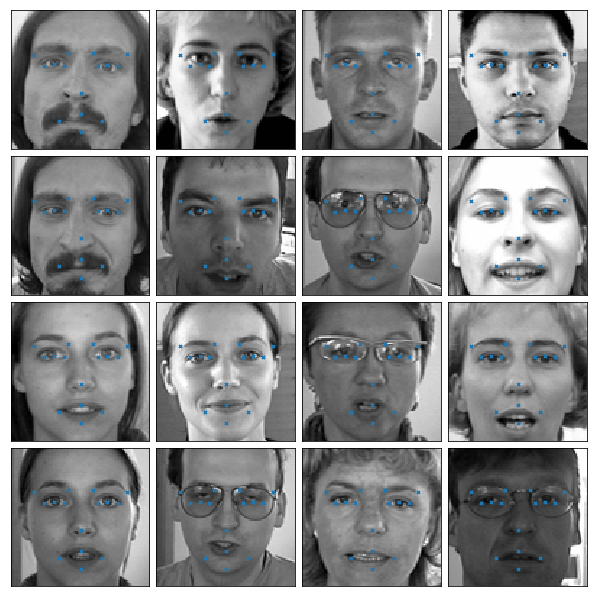

In [19]:
import matplotlib.pyplot as plt

test_rows = np.atleast_2d(X[train_size:train_size + 16])
y_pred = model.predict(test_rows)

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(test_rows)):
    sub = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    img = np.reshape(test_rows[i], (96, 96))
    sub.imshow(img, cmap='gray')
    sub.scatter(y_pred[i][0::2] * 48 + 48, y_pred[i][1::2] * 48 + 48, marker='x', s=10)

plt.show()